In [1]:
# Imports

# Standard Python Data Science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pytorch imports
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchtext.data.utils import get_tokenizer

In [2]:
# Partly taken from https://github.com/prakashpandey9/Text-Classification-Pytorch
class SelfAttention(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, weights):
        super(SelfAttention, self).__init__()

        """
        Arguments
        ---------
        batch_size : Size of the batch which is same as the batch_size of the data returned by the TorchText BucketIterator
        output_size : 2 = (pos, neg)
        hidden_sie : Size of the hidden_state of the LSTM
        vocab_size : Size of the vocabulary containing unique words
        embedding_length : Embeddding dimension of GloVe word embeddings
        weights : Pre-trained GloVe word_embeddings which we will use to create our word_embedding look-up table 
        
        --------
        
        """

        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.weights = weights

        self.word_embeddings = nn.Embedding(vocab_size, embedding_length)
        self.word_embeddings.weights = nn.Parameter(weights, requires_grad=False)
        self.dropout = 0.8
        self.bilstm = nn.LSTM(embedding_length, hidden_size, dropout=self.dropout, bidirectional=True)
        # We will use da = 350, r = 30 & penalization_coeff = 1 
        # as per given in the self-attention original ICLR paper
        self.W_s1 = nn.Linear(2*hidden_size, 350)
        self.W_s2 = nn.Linear(350, 30)
        self.fc_layer = nn.Linear(30*2*hidden_size, 2000)
        self.label = nn.Linear(2000, output_size)

    def attention_net(self, lstm_output):

        """
        Now we will use self attention mechanism to produce a matrix 
        embedding of the input sentence in which every row represents an
        encoding of the input sentence but giving an attention to a 
        specific part of the sentence. We will use 30 such embedding of 
        the input sentence and then finally we will concatenate all the 30 
        sentence embedding vectors and connect it to a fully connected layer 
        of size 2000 which will be connected to the output layer of size 2 
        returning logits for our two classes i.e., pos & neg.
        
        Arguments
        ---------
        lstm_output = A tensor containing hidden states corresponding to each time step of the LSTM network.
        ---------
        Returns : Final Attention weight matrix for all the 30 different sentence embedding in which each of 30 embeddings give
                  attention to different parts of the input sentence.
        Tensor size : lstm_output.size() = (batch_size, num_seq, 2*hidden_size)
                      attn_weight_matrix.size() = (batch_size, 30, num_seq)
        """
        attn_weight_matrix = self.W_s2(F.tanh(self.W_s1(lstm_output)))
        attn_weight_matrix = attn_weight_matrix.permute(0, 2, 1)
        attn_weight_matrix = F.softmax(attn_weight_matrix, dim=2)

        return attn_weight_matrix

    def forward(self, input_sentences, batch_size=None, return_attn=False):

        """ 
        Parameters
        ----------
        input_sentence: input_sentence of shape = (batch_size, num_sequences)
        batch_size : default = None. 
        Used only for prediction on a single sentence after training (batch_size = 1)
        return_attn : bool determining whether to return attention layer activation 
                      default = False
        
        Returns
        -------
        Output of the linear layer containing logits for pos & neg class.
        Attention layer if the return_attn is set
        
        """

        input = self.word_embeddings(input_sentences)
        input = input.permute(1, 0, 2)
        if batch_size is None:
            h_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(2, self.batch_size, self.hidden_size).cuda())
        else:
            h_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(2, batch_size, self.hidden_size).cuda())

        output, (h_n, c_n) = self.bilstm(input, (h_0, c_0))
        output = output.permute(1, 0, 2)
        # output.size() = (batch_size, num_seq, 2*hidden_size)
        # h_n.size() = (1, batch_size, hidden_size)
        # c_n.size() = (1, batch_size, hidden_size)
        attn_weight_matrix = self.attention_net(output)
        # attn_weight_matrix.size() = (batch_size, r, num_seq)
        # output.size() = (batch_size, num_seq, 2*hidden_size)
        hidden_matrix = torch.bmm(attn_weight_matrix, output)
        # hidden_matrix.size() = (batch_size, r, 2*hidden_size)
        # Let's now concatenate the hidden_matrix and connect it to the fully connected layer.
        fc_out = self.fc_layer(hidden_matrix.view(-1, hidden_matrix.size()[1]*hidden_matrix.size()[2]))
        logits = self.label(fc_out)
        # logits.size() = (batch_size, output_size)
        if not return_attn:
            return logits
        else:
            return logits, attn_weight_matrix

In [3]:
def read_embeddings(filename, vocab_size=10000, compute_avg=True):
    """
    Utility function, loads in the `vocab_size` most common embeddings from `filename`
  
    Arguments:
      - filename:     path to file
                      automatically infers correct embedding dimension from filename
      - vocab_size:   maximum number of embeddings to load
      - compute_avg:  bool to decide whether to comnpute the average word embedding,
                      which can be used as a <unk> embedding

      Returns 
      - embeddings:   torch.FloatTensor matrix of size (vocab_size x word_embedding_dim)
      - vocab:        dictionary mapping word (str) to index (int) in embedding matrix
    """

    # get the embedding size from the first embedding
    with open(filename, encoding="utf-8") as file:
        word_embedding_dim = len(file.readline().split(" ")) - 1

    vocab = {}
    inv_vocab = {}
    
    if compute_avg:
        # Add extra embedding for <unk> and <pad>
        # last index is <unk>, first index is <pad>
        embeddings = np.zeros((vocab_size + 2, word_embedding_dim))
    else:
         # Only add extra embedding for <pad>
         # first index is <pad>
        embeddings = np.zeros((vocab_size + 1, word_embedding_dim))
        

    with open(filename, encoding="utf-8") as file:
        for idx, line in enumerate(file):

            if idx >= vocab_size:
                break
            
            cols = line.rstrip().split(" ")
            val = np.array(cols[1:])
            word = cols[0]
            embeddings[idx + 1] = val
            vocab[word] = idx + 1
            inv_vocab[idx + 1] = word
    
    # Set <unk> embedding to the average of all other embedding vects in vocab
    if compute_avg:
        embeddings[-1] = embeddings[:-1].mean(axis=0)
    
    return torch.FloatTensor(embeddings), vocab, inv_vocab

In [4]:
def sent_embedd(sent, model, vocab_dict, tokenizer, max_length, unk_embedd=True):
    '''
    Helper function to extract the embedding for an input sentence.
    '''
    idxs = [0 for i in range(max_length)]
    i = 0
    for word in tokenizer(sent):
        if i < max_length:
            if word in vocab_dict:
                idxs[i] = vocab_dict[word]
            else:
                # If using <unk> embedding, append 
                # the final index where that embedding is stored
                if unk_embedd:
                    idxs[i] = len(vocab_dict)
            i += 1
    return torch.LongTensor([idxs]).to(device)
            
def sent_pred(sent, model, vocab_dict, max_length):
    '''
    Runs the model on an input sentence.
    
    Arguments: 
    
      sent : str. The input sentence.
      model : the pytorch model to be used.
      vocab_dict : dict. A dictionary with words as keys and their indices as values
     
    Returns:
      pred : np array. The prediction, wich is a normalized array with a value for \
             each class, representing the predicted probability for that class
      attns : the attention matrix
    '''
    input_tensor = sent_embedd(sent, model, vocab_dict, max_length)
    pred, attns = model(input_tensor, return_attn=True)
    return pred.detach().cpu().numpy(), attns

In [5]:
def train_single(input_tensor_batch, target_tensor_batch, model, 
          model_optimizer, criterion):
    '''
    A single forward and backward pass of the neural net on a single training batch.
    '''
    target_tensor = torch.stack(target_tensor_batch).reshape(len(input_tensor_batch))
    input_tensor = torch.stack(input_tensor_batch)
    input_tensor = input_tensor.reshape(len(input_tensor_batch), input_tensor.shape[2])
    output = model(input_tensor, return_attn=False)
    loss = criterion(output, target_tensor)
    loss.backward()
    model_optimizer.step()
    return loss.item()

def train(input_tensors, target_tensors, input_val_tensors, target_val_tensors,
          model, model_optimizer, criterion, n_epochs):
    '''
    Train the attention classfier for a given number of epochs on the whole training set.
    '''
    losses = []
    train_accs = []
    val_accs = []
    # Iterate over given num of epochs
    for epoch in range(n_epochs):
        loss = 0
        # Iterate over batches
        for i in range(len(input_tensors)):
            input_tensor = input_tensors[i]
            target_tensor = target_tensors[i]
            loss += train_single(input_tensor, target_tensor, model, 
                                 model_optimizer, criterion)
        train_accuracy = get_accuracy(input_tensors, target_tensors, model)
        val_accuracy = get_accuracy(input_val_tensors, target_val_tensors, model)
        print(f"Epoch {epoch} :") 
        print(f"\tLoss {loss/len(input_tensors):.4f}")
        print(f"\tTraining Accuracy {train_accuracy:.4f}")
        print(f"\tValidation Accuracy {val_accuracy:.4f}")
        losses.append(loss/len(input_tensors))
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
    return losses, train_accs, val_accs

def get_accuracy(input_tensors, target_tensors, model):
    '''
    Get model accuracy.
    '''
    accs = []
    # Iterate over batches
    for i in range(len(input_tensors)):
        input_tensor_batch = input_tensors[i]
        target_tensor_batch = target_tensors[i]
        target_tensor = torch.stack(target_tensor_batch).reshape(len(input_tensor_batch))
        input_tensor = torch.stack(input_tensor_batch)
        input_tensor = input_tensor.reshape(len(input_tensor_batch), input_tensor.shape[2])
        output = model(input_tensor, return_attn=False)
        # Get classification prediction
        preds = output.argmax(axis=1)
        # Get accuracy of given batch
        batch_acc = ((preds == target_tensor).sum()/target_tensor.shape[0]).item()
        accs.append(batch_acc)
    return np.mean(accs)

In [6]:
unk_embedd = True # Bool for whether to create an embedding for the <unk> token
# Get initial word vector embedings from disk
glove_filename = './GloveEmbeddings/glove.6B.100d.txt' 
glove_embeddings, vocab_dict, inv_vocab_dict = read_embeddings(glove_filename, 
                                                               vocab_size=100000,
                                                               compute_avg=unk_embedd)
# Create tokenizer
tokenizer = get_tokenizer('basic_english')

In [7]:
# Set dimensions and hyperparameters
batch_size = 16
output_size = 2
hidden_size = 100
vocab_size = glove_embeddings.shape[0]
embedding_length = glove_embeddings.shape[1]
learning_rate = 5e-5
max_length = 40 # max sentence length (in tokens)
# Initialize embedding weights
weights = glove_embeddings
# Create model
model = SelfAttention(batch_size, output_size, hidden_size, vocab_size, 
                      embedding_length, weights)
#Define model optimizer
model_optimizer = optim.SGD(model.parameters(), lr=learning_rate)
# Use cross entropy loss
criterion = nn.CrossEntropyLoss()
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/dmac/.local/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.8 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


SelfAttention(
  (word_embeddings): Embedding(100002, 100)
  (bilstm): LSTM(100, 100, dropout=0.8, bidirectional=True)
  (W_s1): Linear(in_features=200, out_features=350, bias=True)
  (W_s2): Linear(in_features=350, out_features=30, bias=True)
  (fc_layer): Linear(in_features=6000, out_features=2000, bias=True)
  (label): Linear(in_features=2000, out_features=2, bias=True)
)

In [8]:
# pred, attns = sent_pred('the world is red', model, vocab_dict)
# print(pred)
# print(attns.sum(axis=1).reshape(attns.shape[2]).detach().cpu().numpy())

In [9]:
train_file = "../cross_style_transfer_internal/data/xslue/StanfordPoliteness/train.tsv"
dev_file = "../cross_style_transfer_internal/data/xslue/StanfordPoliteness/dev.tsv"

train_data = pd.read_csv(train_file, names=['domain', 'id', 'text', 'score'], sep='\t')
val_data = pd.read_csv(dev_file, names=['domain', 'id', 'text', 'score'], sep='\t')

In [10]:
def parse_stanford_politeness(polite_df):
    '''
    Parse stanford politeness dataframe into the format we need for classification.
    '''
    input_df = pd.DataFrame()
    input_df['text'] = polite_df['text']
    # Map scores >= 0 (polite) to label 1 and scores < 0 (impolite) to label 0.
    input_df['label'] = polite_df['score'].apply(lambda x : int(x >= 0))
    return input_df

def df_to_training_pairs(df, batch_size, max_length):
    input_tensors = df['text'].apply(lambda x : sent_embedd(x, model, vocab_dict, tokenizer, max_length))
    target_tensors = df['label'].apply(lambda x : torch.LongTensor([x]).to(device))
    return input_tensors.values.reshape(-1, batch_size).tolist(), target_tensors.values.reshape(-1, batch_size).tolist()

In [11]:
train_df = parse_stanford_politeness(train_data)
val_df = parse_stanford_politeness(val_data)

In [12]:
train_df.head()

,text,label
0,Where did you learn English? How come you're t...,0
1,Thanks very much for your edit to the <url> ar...,1
2,Sir i think u hav many friends on wiki who can...,0
3,I can't find it. Maybe I didn't manage to gue...,1
4,"I can't spend too much time, and I'm no specia...",1


In [13]:
# Testing a single pass on a single input

# sent = input_df['text'].iloc[0]
# target_tensor = torch.LongTensor([input_df['label'].iloc[0]]).to(device)
# input_tensor = sent_embedd(sent, model, vocab_dict)
# train_single(input_tensor, target_tensor, model, 
#           model_optimizer, criterion)

In [14]:
input_tensors, target_tensors = df_to_training_pairs(train_df.head((len(train_df)//batch_size)*batch_size), 
                                                                   batch_size, max_length)

input_val_tensors, target_val_tensors = df_to_training_pairs(val_df.head((len(val_df)//batch_size)*batch_size), 
                                                                   batch_size, max_length)

In [15]:
train(input_tensors, target_tensors, input_val_tensors, target_val_tensors, 
      model, model_optimizer, criterion, 20)

/home/dmac/.local/lib/python3.8/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0 :
	Loss 0.6881
	Training Accuracy 0.5755
	Validation Accuracy 0.5739
Epoch 1 :
	Loss 0.6943
	Training Accuracy 0.5509
	Validation Accuracy 0.5568
Epoch 2 :
	Loss 0.7038
	Training Accuracy 0.5496
	Validation Accuracy 0.5587
Epoch 3 :
	Loss 0.7067
	Training Accuracy 0.5580
	Validation Accuracy 0.5625
Epoch 4 :
	Loss 0.7025
	Training Accuracy 0.5680
	Validation Accuracy 0.5720
Epoch 5 :
	Loss 0.7057
	Training Accuracy 0.5231
	Validation Accuracy 0.5133
Epoch 6 :
	Loss 0.7202
	Training Accuracy 0.5632
	Validation Accuracy 0.5492
Epoch 7 :
	Loss 0.6900
	Training Accuracy 0.5841
	Validation Accuracy 0.5436
Epoch 8 :
	Loss 0.6641
	Training Accuracy 0.5872
	Validation Accuracy 0.5644
Epoch 9 :
	Loss 0.6656
	Training Accuracy 0.6279
	Validation Accuracy 0.5928
Epoch 10 :
	Loss 0.6803
	Training Accuracy 0.6133
	Validation Accuracy 0.5947
Epoch 11 :
	Loss 0.6654
	Training Accuracy 0.6439
	Validation Accuracy 0.6023
Epoch 12 :
	Loss 0.6298
	Training Accuracy 0.6420
	Validation Accuracy 0.6

([0.6881055099430022,
  0.6943177017685654,
  0.7038455501005247,
  0.7066699025015553,
  0.7025346806297055,
  0.7057447461048504,
  0.7202064522675106,
  0.6899715457837303,
  0.6641012302466801,
  0.6655831758368325,
  0.6803252941795758,
  0.6654025166259183,
  0.629844592279428,
  0.6555914195714059,
  0.6116804084801054,
  0.6397476038085176,
  0.6764576588454959,
  0.6620258017406835,
  0.6014392430615889,
  0.5935664949091998],
 [0.575487012987013,
  0.5509334415584416,
  0.549614448051948,
  0.5580357142857143,
  0.5679788961038961,
  0.5231331168831169,
  0.5632102272727273,
  0.5841112012987013,
  0.5871550324675324,
  0.6279423701298701,
  0.6133319805194806,
  0.6438717532467533,
  0.6420454545454546,
  0.5880681818181818,
  0.6815137987012987,
  0.6518871753246753,
  0.6290584415584416,
  0.6751217532467533,
  0.643161525974026,
  0.6920657467532467],
 [0.5738636363636364,
  0.5568181818181818,
  0.5587121212121212,
  0.5625,
  0.571969696969697,
  0.5132575757575758,
  0

To do:
- [X] handle unk words better
    - currently initalizing to the average of all word embeddings like suggested [here](https://stackoverflow.com/questions/49239941/what-is-unk-in-the-pretrained-glove-vector-files-e-g-glove-6b-50d-txt)
- [X] make work with batches
- [ ] use different, better embeddings
- [X] use better tokenizer, like spacy or some huggingface transformer model
- [ ] train and save a good model
- [ ] visualize attentions
- [ ] make work with other datasets
- [ ] convert to .py script that runs with input file that determines which data and parameters to use

In [16]:
input_tensor_batch = input_tensors[0]
target_tensor_batch = target_tensors[0]
target_tensor = torch.stack(target_tensor_batch).reshape(len(input_tensor_batch))
input_tensor = torch.stack(input_tensor_batch)
input_tensor = input_tensor.reshape(len(input_tensor_batch), input_tensor.shape[2])
output, attention = model(input_tensor, return_attn=True)

In [29]:
train_df['text'].iloc[0]

"Where did you learn English? How come you're taking on a third language?"

In [27]:
input_tensors[0][0]

tensor([[ 112,  120,   82, 2369,  712,  189,  198,  327,   82,   58, 1766,  583,
           14,    8,  246, 1033,  189,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]], device='cuda:0')

In [34]:
attention[0].sum(axis=0)

tensor([0.0874, 0.1752, 0.4235, 0.0182, 0.0019, 0.0175, 0.4379, 0.0640, 0.4176,
        0.8864, 1.1952, 0.1029, 1.2384, 0.0171, 1.1456, 0.3960, 0.0279, 1.0153,
        1.0151, 1.0151, 1.0151, 1.0151, 1.0151, 1.0151, 1.0151, 1.0151, 1.0151,
        1.0151, 1.0151, 1.0151, 1.0151, 1.0151, 1.0151, 1.0151, 1.0151, 1.0151,
        1.0151, 1.0151, 1.0151, 1.0151], device='cuda:0',
       grad_fn=<SumBackward1>)

In [33]:
tokenizer(train_df['text'].iloc[0])[attention[0].sum(axis=0).argmax().item()]

'on'

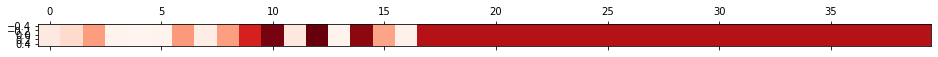

In [50]:
plt.matshow([attention[0].sum(axis=0).cpu().detach().numpy()], cmap='Reds')

In [52]:
attention.shape

torch.Size([16, 30, 40])

In [54]:
tokenizer(train_df['text'].iloc[0])[9]

"'"